# Data Visualization (Event Aggregate Information)

Visualization of hits, charge, timing and energy information for IWCD GEANT4 simulated dataset. <br>
Neutron captures are simulated as the signal (label 0), electron radiative background is simulated as a 0-20MeV background (label 1) 

For more visualizations, see the "Feature Engineering" folder.

In [2]:
# import packages
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy import stats
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from statsmodels.distributions.mixture_rvs import mixture_rvs
%matplotlib inline

In [3]:
#load in h5 file and indices files
h5_filepath = "/home/mattStubbs/watchmal/NeutronGNN/data/h5_files/iwcd_mpmt_shorttank_neutrongnn_50files.h5"
train_indices_file = "/home/mattStubbs/watchmal/NeutronGNN/data/splits/train_indicies_50files.txt"
val_indices_file = "/home/mattStubbs/watchmal/NeutronGNN/data/splits/validation_indicies_50files.txt"
test_indices_file = "/home/mattStubbs/watchmal/NeutronGNN/data/splits/test_indicies_50files.txt"

To access any part of the h5 dataset, <br> 
1) read the h5 file, 2) create a memory mapping to it <br>

looking into the h5 file... <br> 
x_data = [charge, time, pmt_position_x, pmt_position_y, pmt_position_z, pmt_direction_x, pmt_direction_y, pmt_direction_z] <br>
'labels' == particle id, ... , 
'event_data' == x_data

In [4]:
with h5py.File(h5_filepath, 'r') as file:
    print(list(file.keys()))
    h5_event_data = file['event_data']
    h5_nhits = file['nhits']
    h5_labels = file['labels']
    labels = np.array(h5_labels)
    
    event_data = np.memmap(h5_filepath, mode='r', shape=h5_event_data.shape,
                               offset=h5_event_data.id.get_offset(),
                               dtype=h5_event_data.dtype)
    print("Event memory data shape: " + str(event_data.shape))
    print("{} events. Up to {} hits per event. {} features per hit per event".format(h5_event_data.shape[0], h5_event_data.shape[1], h5_event_data.shape[2]))
    nhits = np.array(h5_nhits)
    positions0 = file['positions']   #initial positions of simulated particles
    positions0 = np.array(positions0)
    h5_energy = file["energies"]; h5_energy = np.array(h5_energy)
    h5_charges = event_data[:, :, 0]; h5_charges = np.array(h5_charges)

['angles', 'energies', 'event_data', 'event_ids', 'labels', 'nhits', 'positions', 'root_files']
Event memory data shape: (43961, 300, 8)
43961 events. Up to 300 hits per event. 8 features per hit per event


In [9]:
#sample a few events and aggregate hit totals
for x in range(0, 50000, 10000):
    print("event: {}, label: {}, nhits: {}".format(x, labels[x], nhits[x]))

event: 0, label: 1, nhits: 71
event: 10000, label: 1, nhits: 50
event: 20000, label: 1, nhits: 127
event: 30000, label: 0, nhits: 33
event: 40000, label: 0, nhits: 66


Verify the number of hits per event

In [13]:
non_zero = [np.count_nonzero(event_data[i,:,0]) for i in range(0, event_data.shape[0])]
non_zero  = np.array(non_zero)
# nhits should be equal to non_zero
assert nhits.all() == non_zero.all()

__Visualize PMT hit locations Throughout the Short Tank__
The hits occur on photomultiplier tubes (PMTs) through the circumference of the cylindrical tank (shown below). <br>
The vertices (location of start of event) are distributed throughout the interior of the tank.

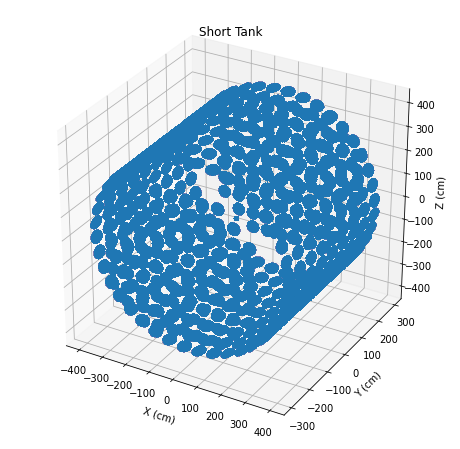

In [17]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    xs=event_data[:, :, 2],
    ys=event_data[:, :, 3],
    zs=event_data[:, :, 4],
    alpha = 0.007,
)
#ax.set_title('Hit Locations of 16,000 events')
ax.set_title('Short Tank')
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')

plt.show()

Visualize vertices, first separating events by event type

In [20]:
# initial positions
npPositions0 = [positions0[i].flatten() for i in range(len(positions0))]

In [21]:
npNeutron0 = []
npElectron0 = []
for x in range(event_data.shape[0]):
    if labels[x]==0:
        npNeutron0.append(positions0[x])
    elif labels[x]==1:
        npElectron0.append(positions0[x])
npNeutron0 = np.array(npNeutron0)
npElectron0 = np.array(npElectron0)

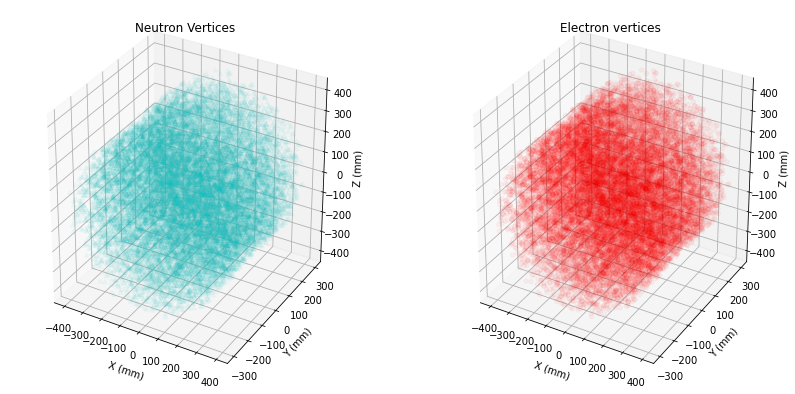

In [25]:
fig = plt.figure(figsize=(14, 7))
#ax = fig.add_subplot(111, projection='3d')
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(
    xs=npNeutron0[:, :, 0],
    ys=npNeutron0[:, :, 1],
    zs=npNeutron0[:, :, 2],
    c='c', marker='^', alpha = 0.04
)

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(
    xs=npNeutron0[:, :, 0],
    ys=npNeutron0[:, :, 1],
    zs=npNeutron0[:, :, 2],
    c='r', marker='o', alpha = 0.04
)


ax1.set_title('Neutron Vertices')
ax2.set_title('Electron vertices')
ax1.set_xlabel('X (mm)'); ax2.set_xlabel('X (mm)')
ax1.set_ylabel('Y (mm)'); ax2.set_ylabel('Y (mm)')
ax1.set_zlabel('Z (mm)'); ax2.set_zlabel('Z (mm)')
plt.show()

# Hits Ditribution

aggregate number of hits within an event

Text(0, 0.5, 'Counts/bin (normalized)')

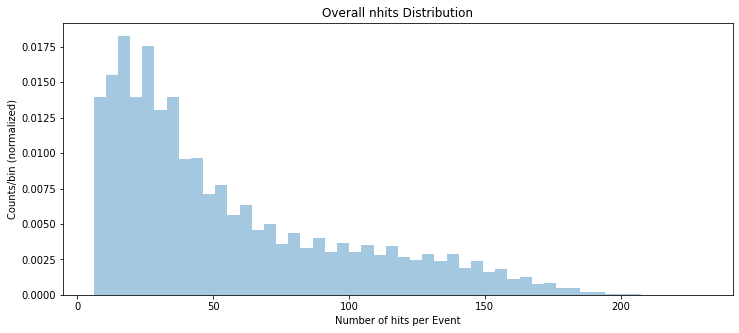

In [26]:
fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot(111) 
sns.distplot(nhits, rug = False, kde=False, axlabel ="Number of hits per Event", norm_hist=True)
plt.title("Overall nhits Distribution")
plt.ylabel("Counts/bin (normalized)")

In [27]:
print(np.unique(labels))

[0 1]


__Separate nhits array based on whether the event is electron or neutron__

get the index of the electron or neutron events. The way the files have been merged, they have not been shuffled yet - so there will be all events of one type, then all events of the next. <br>
label = 0 -> neutron <br>
label = 1 -> electron

In [28]:
neutron_hits = []
electron_hits = []
print(labels.shape)

for i in range(event_data.shape[0]):
    if labels[i] == 0:
        neutron_hits.append(nhits[i])
    elif labels[i] == 1:
        electron_hits.append(nhits[i])

#convert to numpy arrays
neutron_hits = np.array(neutron_hits)
electron_hits = np.array(electron_hits)
        
print('neutron events: {} \t e- events: {}'.format(neutron_hits.shape, electron_hits.shape))

(43961,)
neutron events: (20779,) 	 e- events: (23182,)


In [29]:
# Statistics on the neutron and electron event hit numbers
print(stats.describe(neutron_hits))
print(stats.describe(electron_hits))

DescribeResult(nobs=20779, minmax=(6, 104), mean=28.076615814043024, variance=236.69390834652245, skewness=0.8439650949073764, kurtosis=0.32009922516849887)
DescribeResult(nobs=23182, minmax=(6, 230), mean=79.44974549219222, variance=2061.180404361262, skewness=0.3070112150226877, kurtosis=-0.8449815425294851)


Visualize difference between hit distributions of neutron and electron events. Fit kernel density estimate.

Text(0, 0.5, 'Counts/bin (normalized)')

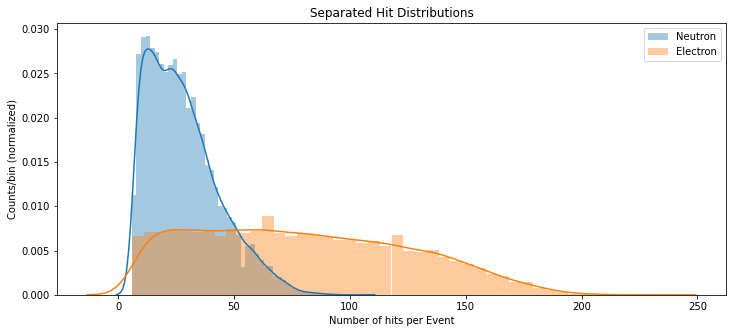

In [30]:
fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot(111) 
sns.distplot(neutron_hits, rug = False, axlabel ="Number of hits per Event", label = "Neutron")
sns.distplot(electron_hits, rug = False, label = "Electron")
plt.legend()
plt.title("Separated Hit Distributions")
plt.ylabel("Counts/bin (normalized)")
#plt.savefig("hit_separation.png", bbox_inches='tight') 

# Charge

aggregate charge within an event

sum charge within an event

In [37]:
q_sums = h5_charges.sum(axis = 1)
q_sums = np.array(q_sums)

overall distribution:

Text(0, 0.5, 'Counts/bin (normalized)')

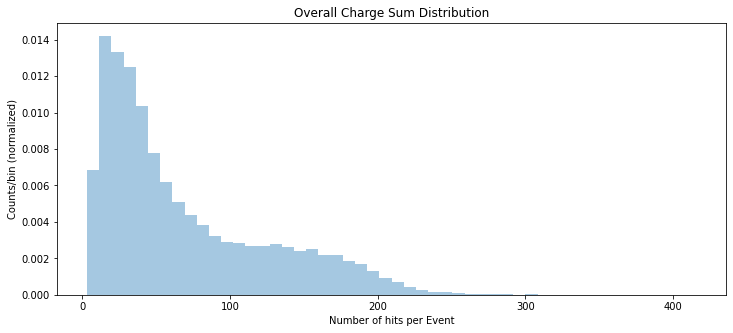

In [39]:
fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot(111) 
sns.distplot(q_sums, rug = False, kde=False, axlabel ="Number of hits per Event", norm_hist=True)
plt.title("Overall Charge Sum Distribution")
plt.ylabel("Counts/bin (normalized)")

separate by particle type, analagous to aggregate hits

In [40]:
neutron_charge_sums = []
electron_charge_sums = []

for i in range(event_data.shape[0]):
    if labels[i] == 0:
        neutron_charge_sums.append(q_sums[i])
    elif labels[i] == 1:
        electron_charge_sums.append(q_sums[i])   

In [41]:
# few samples 
print(neutron_charge_sums[:15])
print(electron_charge_sums[:15])

[41.584465, 43.12234, 7.0457644, 22.84306, 12.510172, 61.502735, 29.011889, 23.144814, 11.292397, 22.060467, 19.665867, 24.311583, 25.689318, 25.410654, 30.432682]
[90.71265, 40.10595, 53.739975, 190.99295, 40.67142, 107.36137, 71.77139, 157.61174, 35.43709, 212.51834, 170.2475, 142.61873, 24.210955, 200.87871, 227.72697]


neutron charge stats ... 
DescribeResult(nobs=20779, minmax=(3.2661016, 208.25096), mean=32.881374, variance=352.38416, skewness=1.0349177122116089, kurtosis=1.6182548260233647)

electron charge stats ... 
DescribeResult(nobs=23182, minmax=(4.634709, 415.6129), mean=101.98235, variance=3498.439, skewness=0.34979233145713806, kurtosis=-0.5147333341032878)


Text(0, 0.5, 'Counts/bin (normalized)')

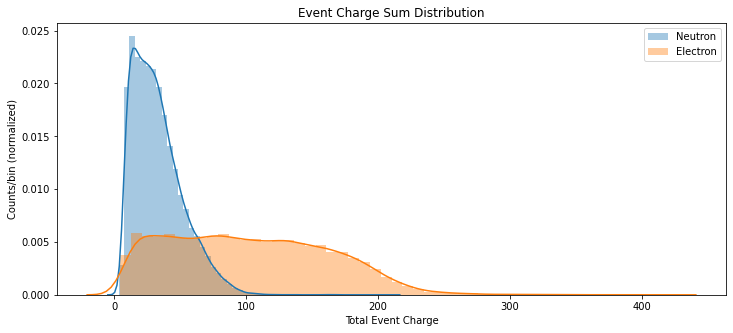

In [42]:
print("neutron charge stats ... \n" + str(stats.describe(neutron_charge_sums))), print("")
print("electron charge stats ... \n" + str(stats.describe(electron_charge_sums)))

fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(111) 

ax = sns.distplot(neutron_charge_sums, rug = False, axlabel ="Total Event Charge", label = "Neutron")
ax = sns.distplot(electron_charge_sums, rug = False, label = "Electron")
plt.legend()
plt.title("Event Charge Sum Distribution")
plt.ylabel("Counts/bin (normalized)")
#plt.savefig("charge_separation.png", bbox_inches = 'tight', dpi=600) 

__2d charge/hits perspective__

plot charge/hits 2d jointplot with 6 major contours

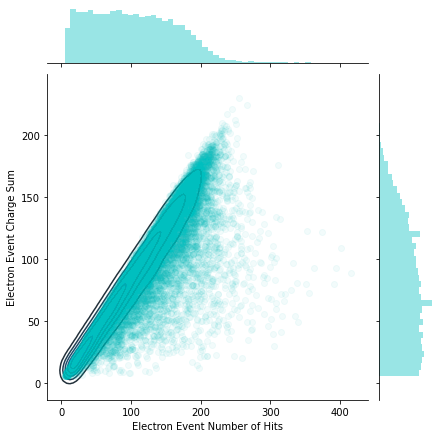

In [43]:
g = (sns.jointplot(electron_charge_sums, electron_hits,
                  color = 'c', height = 6, alpha = 0.05)
                  .plot_joint(sns.kdeplot, zorder=0, n_levels=6).set_axis_labels("Electron Event Number of Hits", "Electron Event Charge Sum"))

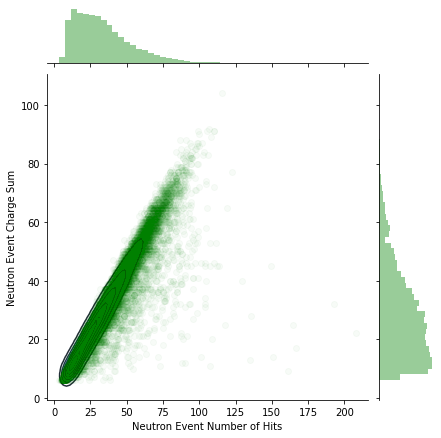

In [44]:
h = (sns.jointplot(neutron_charge_sums, neutron_hits,
                  color = 'g', height = 6, alpha = 0.03)
                  .plot_joint(sns.kdeplot, zorder=0, n_levels=6).set_axis_labels("Neutron Event Number of Hits", "Neutron Event Charge Sum"))

We see a good deal of overlap between the shape of the 2d contours, although the scale is reduced for neutron events with hits, charge numbers

# Timing

In [45]:
neutron_times = []; neutron_indices = []
electron_times = []; electron_indices = []

for i in range(event_data.shape[0]):
    if labels[i] == 0:
        neutron_times.append(event_data[i, :, 1])
        neutron_indices.append(i)
    elif labels[i] == 1:
        electron_times.append(event_data[i, :, 1])   
        electron_indices.append(i)

In [46]:
neutron_times = np.array(neutron_times)
electron_times = np.array(electron_times)

print(neutron_times.shape)
print(electron_times.shape)

(20779, 300)
(23182, 300)


__average, min, max and range of event times__

In [47]:
neutron_timeRange = []; neutron_minTimes = []; neutron_maxTimes = []; neutron_meanTimes = []
e_timeRange = []; e_minTimes = []; e_maxTimes = []; e_meanTimes = []

for i in range(len(neutron_times)):
    neutron_timeRange.append(max(neutron_times[i, :nhits[neutron_indices[i]]]) - min(neutron_times[i, :nhits[neutron_indices[i]]]))
    neutron_minTimes.append(min(neutron_times[i, :nhits[neutron_indices[i]]]))
    neutron_maxTimes.append(max(neutron_times[i, :nhits[neutron_indices[i]]]))
    neutron_meanTimes.append(np.average(neutron_times[i, :nhits[neutron_indices[i]]]))
    
for i in range(len(electron_times)):
    e_timeRange.append(max(electron_times[i, :nhits[electron_indices[i]]]) - min(electron_times[i, :nhits[electron_indices[i]]]))
    e_minTimes.append(min(electron_times[i, :nhits[electron_indices[i]]]))
    e_maxTimes.append(max(electron_times[i, :nhits[electron_indices[i]]]))
    e_meanTimes.append(np.average(electron_times[i, :nhits[electron_indices[i]]]))

__mean times__

These mean times have a similar peak around 970-975ns, however the electron mean time variance is much more constrained. The variance of the neutron mean times is over 2x greater.

In [48]:
print("neutron mean times ... \n" + str(stats.describe(neutron_meanTimes))), print("")
print("electron mean times ... \n" + str(stats.describe(e_meanTimes)))

neutron mean times ... 
DescribeResult(nobs=20779, minmax=(859.2908, 1249.2548), mean=976.9038, variance=896.2424, skewness=1.6591020822525024, kurtosis=5.637940589607046)

electron mean times ... 
DescribeResult(nobs=23182, minmax=(876.4, 1214.3734), mean=971.3221, variance=299.34592, skewness=3.0106823444366455, kurtosis=22.019397388472267)


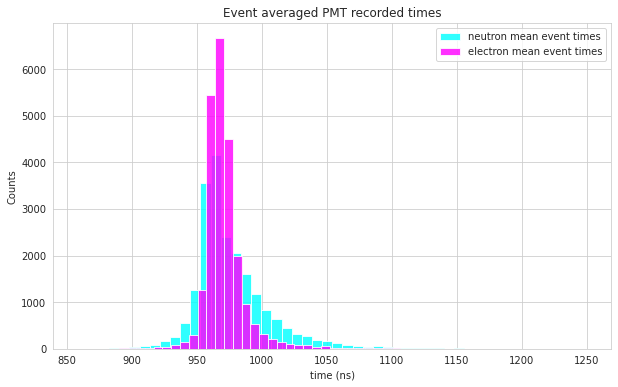

In [50]:
sns.set_style('whitegrid')
plt.figure(figsize = (10,6))
plt.hist(neutron_meanTimes, color = 'cyan', bins=50, alpha = 0.81, label = 'neutron mean event times')
plt.hist(e_meanTimes, color = 'magenta', bins=50, alpha = 0.81, label = 'electron mean event times')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.title("Event averaged PMT recorded times")
plt.legend()

__event time of flight__

the time of flight distributions are quite similar here, although we do see more neutron events having a shorter time of flight. However, this metric (time of flight) is highly sensitive to dark noise PMT hits

In [51]:
print(stats.describe(neutron_timeRange))
print(stats.describe(e_timeRange))

DescribeResult(nobs=20779, minmax=(2.9003906, 1344.4004), mean=437.82275, variance=119462.75, skewness=0.38361209630966187, kurtosis=-1.0955524017686376)
DescribeResult(nobs=23182, minmax=(2.7000122, 1346.7), mean=439.76205, variance=114775.21, skewness=0.42899999022483826, kurtosis=-1.027859217154471)


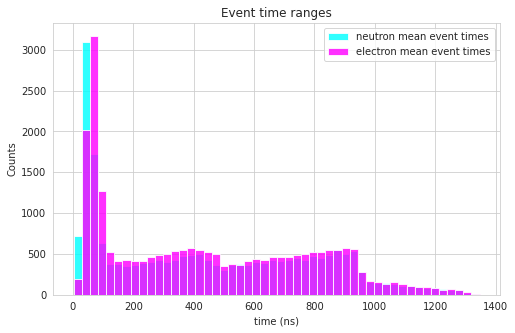

In [52]:
sns.set_style('whitegrid')
plt.figure(figsize = (8,5))
plt.hist(neutron_timeRange, color = 'cyan', bins=50, alpha = 0.81, label = 'neutron mean event times')
plt.hist(e_timeRange, color = 'magenta', bins=50, alpha = 0.81, label = 'electron mean event times')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.title("Event time ranges")
plt.legend()

__min times__

Up until just after 900ns, we see a few hits from dark noise. After that, the neutron/electron distributions are similar although there is a greater number of neutron events starting at earlier times

In [53]:
print(stats.describe(neutron_minTimes))
print(stats.describe(e_minTimes))

DescribeResult(nobs=20779, minmax=(550.0, 953.7012), mean=874.80023, variance=14456.9, skewness=-1.430097222328186, kurtosis=0.5365452735872691)
DescribeResult(nobs=23182, minmax=(550.0, 953.9), mean=877.3345, variance=14541.178, skewness=-1.4284864664077759, kurtosis=0.5298854260933865)


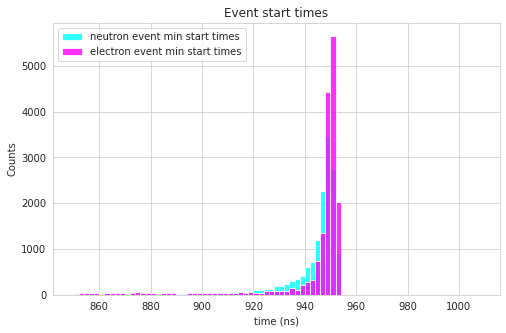

In [54]:
sns.set_style('whitegrid')
plt.figure(figsize = (8,5))
plt.hist(neutron_minTimes, color = 'cyan', bins=np.arange(850,1010, 2), alpha = 0.81, label = 'neutron event min start times')
plt.hist(e_minTimes, color = 'magenta', bins=np.arange(850,1010, 2), alpha = 0.81, label = 'electron event min start times')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.title("Event start times")
plt.legend()

__max times__

In [57]:
print(stats.describe(neutron_maxTimes))
print(stats.describe(e_maxTimes))
from statistics import median
print(median(neutron_maxTimes))
print(median(e_maxTimes))

DescribeResult(nobs=20779, minmax=(950.0, 1900.002), mean=1312.6229, variance=104512.14, skewness=0.3996196985244751, kurtosis=-1.4068991215765172)
DescribeResult(nobs=23182, minmax=(950.0, 1900.0), mean=1317.0966, variance=99762.99, skewness=0.4383508265018463, kurtosis=-1.3789801813780256)
1231.0
1222.14990234375


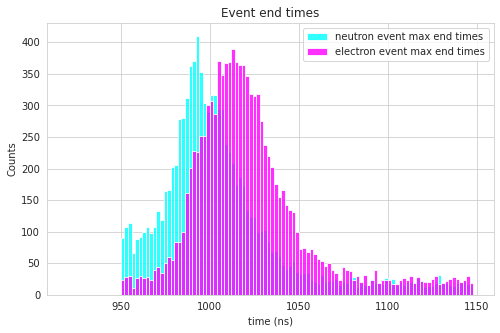

In [63]:
sns.set_style('whitegrid')
plt.figure(figsize = (8,5))
plt.hist(neutron_maxTimes, color = 'cyan', bins=np.arange(920,1150,2), alpha = 0.81, label = 'neutron event max end times')
plt.hist(e_maxTimes, color = 'magenta', bins=np.arange(920,1150,2), alpha = 0.81, label = 'electron event max end times')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.title("Event end times")
plt.legend()

# Energy

In [5]:
h5_energy = np.reshape(h5_energy, (len(h5_energy), -1))
h5_energy = h5_energy.flatten()

In [6]:
print(h5_energy.shape)

(43961,)


In [7]:
print(h5_energy[:10])

[ 9.703471   6.893087   6.392733  15.772576   4.0892606 10.898928
  7.5624266 15.9206085 14.884148  20.420986 ]


Events are either 0-20MeV for electron events (simulated energy distribution) and around 940.6MeV for neutron captures (de-excitation until minimum energy threshold for capture)

Text(0, 0.5, 'Counts/bin')

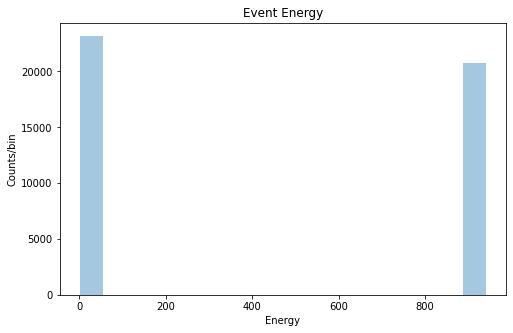

In [8]:
fig = plt.figure(figsize = (8, 5))
ax = fig.add_subplot(111) 
sns.distplot(h5_energy, rug = False, kde=False, axlabel ="Energy", norm_hist=False)
plt.title("Event Energy")
plt.ylabel("Counts/bin")

In [9]:
neutron_energies = []
e_energies = []

for i, j in enumerate(h5_energy):
    if labels[i] == 0: #muon
        neutron_energies.append(j)
    elif labels[i] == 1:  #electron
        e_energies.append(j)

Text(0, 0.5, 'Counts/bin')

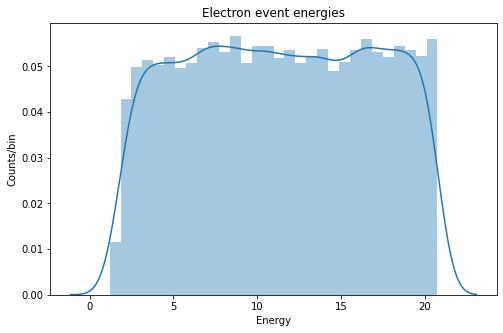

In [10]:
fig = plt.figure(figsize = (8, 5))
ax = fig.add_subplot(111) 
sns.distplot(e_energies, rug = False, kde=True, axlabel ="Energy", norm_hist=False)
plt.title("Electron event energies")
plt.ylabel("Counts/bin")

In [12]:
print(stats.describe(neutron_energies))
# Neutron energy is always exactly 940.5637 MeV

DescribeResult(nobs=20779, minmax=(940.56537, 940.56537), mean=940.56537, variance=0.0, skewness=0.0, kurtosis=-3.0)


In [13]:
print(neutron_energies[:10])
print(e_energies[:10])

[940.56537, 940.56537, 940.56537, 940.56537, 940.56537, 940.56537, 940.56537, 940.56537, 940.56537, 940.56537]
[9.703471, 6.893087, 6.392733, 15.772576, 4.0892606, 10.898928, 7.5624266, 15.9206085, 14.884148, 20.420986]
